# GRU 242
Test the RNA length effect.

In [67]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=100  # use 2 for debug, 200 for real
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='GRU242'
NEURONS=16
ACT="tanh"
DROP=0.5


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [69]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    embed_layer  = keras.layers.Embedding(
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
        input_dim=VOCABULARY_SIZE, output_dim=EMBED_DIMEN, mask_zero=True)
    #rnn1_layer = keras.layers.Bidirectional(
    rnn1_layer = keras.layers.GRU(NEURONS, return_sequences=False,  #   True, 
          input_shape=[1000,EMBED_DIMEN], activation=ACT, dropout=DROP)#)#bi
    #rnn2_layer = keras.layers.Bidirectional(
    rnn2_layer = keras.layers.GRU(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP)#)#bi
    dense1_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    drop1_layer = keras.layers.Dropout(DROP)
    #dense2_layer = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    #drop2_layer = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)
    mlp = keras.models.Sequential()
    mlp.add(embed_layer)
    mlp.add(rnn1_layer)
    #mlp.add(rnn2_layer)
    mlp.add(dense1_layer)
    mlp.add(drop1_layer)
    #mlp.add(dense2_layer)
    #mlp.add(drop2_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [70]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [71]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [72]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [73]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen < '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [74]:
bestname=DATAPATH+FILENAME+".best"
def just_train(X,y): # give me training set
    model=build_model()
    print(model.summary())
    mycallbacks = [keras.callbacks.ModelCheckpoint(
        filepath=bestname, save_best_only=True, 
        monitor='accuracy', mode='max')]   
    print("FIT")
    start_time=time.time()
    history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
            callbacks=mycallbacks )  # no validation data
    end_time=time.time()
    elapsed_time=(end_time-start_time)                        
    print("Train %d epochs, %d sec"%(EPOCHS,elapsed_time))
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
def just_evaluate(X,y):  # give me validation set
    best_model=keras.models.load_model(bestname)
    scores = best_model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

## Train on RNA length-based slice

In [75]:
#      A    B    C     D     E     F
# 200, 500, 750, 1000, 1500, 3000, 30000 
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
together=pd.concat((nc_seq,pc_seq),axis=0)
train_set=together.sample(frac=1)   # shuffle
together=None
nc_seq=None
pc_seq=None
def get_x_and_y(train_set,minlen,maxlen):
  subset=make_slice(train_set,minlen,maxlen)
  (X_set,y_set)=make_kmers(maxlen,subset)
  print("Shape of X is "+str(X_set.shape))
  L=len(X_set)
  T=int(0.80*L+0.5)
  print("Total %d, Train portion %d"%(L,T))
  X_train=X_set[:T]
  y_train=y_set[:T]
  X_valid=X_set[T:]
  y_valid=y_set[T:]
  return (X_train,y_train,X_valid,y_valid)

MINLEN=900
MAXLEN=1300
(X_train,y_train,X_valid,y_valid)=get_x_and_y(train_set,MINLEN,MAXLEN)
print("Loaded")

Load data from files.
Shape of X is (4478, 1300)
Total 4478, Train portion 3582
Loaded


Train on  900 - 1300
COMPILE...
...COMPILED
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          1040      
_________________________________________________________________
gru_12 (GRU)                 (None, 16)                1632      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 2,961
Trainable params: 2,961
Non-trainable params: 0
_________________________________________________________________
None
FIT
Epoch 1/100
112/112 [==============================] - 15s 134ms/

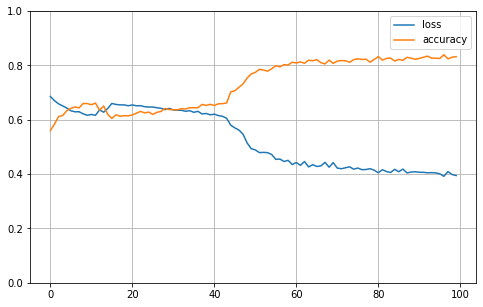

In [76]:
print ("Train on ",MINLEN,"-",MAXLEN)
just_train(X_train,y_train)  


In [77]:
print ("Evaluate on A")
(X_train,y_train,X_valid_A,y_valid_A)=get_x_and_y(train_set,200,600)
just_evaluate(X_valid_A,y_valid_A) 
(X_valid_A,y_valid_A)=(None,None)
print ("Evaluate on B")
(X_train,y_train,X_valid_B,y_valid_B)=get_x_and_y(train_set,600,900)
just_evaluate(X_valid_B,y_valid_B)  
(X_valid_B,y_valid_B)=(None,None)
print ("Evaluate on C")
(X_train,y_train,X_valid_C,y_valid_C)=get_x_and_y(train_set,900,1300)
just_evaluate(X_valid_C,y_valid_C)  
(X_valid_C,y_valid_C)=(None,None)
print ("Evaluate on D")
(X_train,y_train,X_valid_D,y_valid_D)=get_x_and_y(train_set,1300,1900)
just_evaluate(X_valid_D,y_valid_D)  
(X_valid_D,y_valid_D)=(None,None)
print ("Evaluate on E")
(X_train,y_train,X_valid_E,y_valid_E)=get_x_and_y(train_set,1900,3000)
just_evaluate(X_valid_E,y_valid_E)  
(X_valid_E,y_valid_E)=(None,None)
print ("Evaluate on F")
(X_train,y_train,X_valid_F,y_valid_F)=get_x_and_y(train_set,3000,30000)
just_evaluate(X_valid_F,y_valid_F) 
(X_valid_F,y_valid_F)=(None,None) 

print ("Done")

Evaluate on A
Shape of X is (8165, 600)
Total 8165, Train portion 6532
[[ 2  8 31 ...  0  0  0]
 [19 12 48 ...  0  0  0]
 [56 29 52 ...  0  0  0]
 ...
 [17  1  3 ...  0  0  0]
 [43 42 40 ...  0  0  0]
 [33  4 15 ...  0  0  0]]
accuracy: 62.83%
Evaluate on B
Shape of X is (6442, 900)
Total 6442, Train portion 5154
accuracy: 74.53%
Evaluate on C
Shape of X is (4478, 1300)
Total 4478, Train portion 3582
accuracy: 78.46%
Evaluate on D
Shape of X is (4421, 1900)
Total 4421, Train portion 3537
accuracy: 80.88%
Evaluate on E
Shape of X is (4590, 3000)
Total 4590, Train portion 3672
accuracy: 85.73%
Evaluate on F
Shape of X is (3900, 30000)
Total 3900, Train portion 3120
accuracy: 73.59%
Done
